# Introduction

In this document we will explore and analysis the dataset about the property transaction in **Vaud** a Switzerland Canton.

This dataset has been built by collecting data from many various datasources in a ETL process. This first process is not part of this document and will be describe in anothers docs.

The aim of this dataset is to create a model to predict which owner will sell in the next year in the Vaud canton. It will be a binary classification problem and the target class is the column *isSelling*

This analysis is numeroted as V1-1 as its the first analysis of the dataset that will be use to create the version V1 of the model. Based on the recommendation in this document, some modification will be done on the dataset that will result in a second version where we will perform a second analysis and feature engineering process.

This second analysis and the process of training the model is not part of this document.

This document include:
* The Pyhton source code used to perform the analysis
* Table, Chart, ... allowing to understand our dataset and perform some corrective action
* Recommendation and/or question resulting from the analysis

_If anyone is interested to add more details or dig more in this analysis, I can provide the Notebook code source. Also if you notice an error, a wrong assumption or judgement, drop me an email_: tclement@popety.com

# INDEX:
1. Configuration
1. Dataset overview
1. Target Class Analysis
1. Feature Analysis
1. Feature Correlation
1. Conclusion


## 1. Configuration

Let us first import the necessary Python modules:

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O
import matplotlib.pyplot as plt # plotting library
import seaborn as sns # visualization library based on matplotlib
color = sns.color_palette()
%matplotlib inline

# Manage UTF-8 issue
import sys  
reload(sys)  
sys.setdefaultencoding('utf8')

and the dataset:

In [2]:
vaud_df = pd.read_csv("../swissmarket-model-vaud-v1-1.csv", parse_dates=["date_sample", "date_transaction", "date_inception"])

## 2. Dataset Overview

Take a look to the size of the dataset:

In [3]:
vaud_df.shape

(126545, 28)

So we have **126545 rows and 28 columns** in the dataset.

The dataset looks like this (only the 5 first rows are display):


In [4]:
vaud_df.head()

,id_pk,current_owner,tx_id_pk,egid,ofs,age_avg,age_sd,age_min,age_max,date_sample,...,nb_of_level_in_property,nb_of_unit_in_property,building_sqmt,is_landed,nb_of_rooms,sqmt,taux_hyp,ipc,indice_loyer,isSelling
0,7,0,73,190087396,136,56,1,55,57,2004-02-10,...,4,3,131,0,3,110,3.25,0.8,1.35,1
1,8,0,111,300000565,132,58,2,56,59,2004-02-10,...,3,9,1140,0,4,63,3.25,0.8,1.35,1
2,9,0,131,280000061,131,77,3,74,81,2004-02-16,...,3,1,130,1,6,194,3.25,0.8,1.35,1
3,11,0,180,280061206,131,57,2,55,59,2004-02-15,...,3,1,323,1,7,327,3.25,0.8,1.35,1
4,12,0,181,190060352,131,57,2,55,59,2004-02-15,...,2,1,226,1,4,138,3.25,0.8,1.35,1



If we take a look to the different datatype in our dataset:


In [5]:
dtype_df = vaud_df.dtypes.reset_index()
dtype_df.columns = ["Count", "Feature Type"]
dtype_df

,Count,Feature Type
0,id_pk,int64
1,current_owner,int64
2,tx_id_pk,int64
3,egid,int64
4,ofs,int64
5,age_avg,int64
6,age_sd,int64
7,age_min,int64
8,age_max,int64
9,date_sample,datetime64[ns]


In [6]:
dtype_df.groupby("Feature Type").aggregate('count').reset_index()

,Feature Type,Count
0,int64,18
1,datetime64[ns],3
2,float64,4
3,object,3


We see that on the 28 columns of the dataset we got:
* 18 Integer type: This can be continuous or ordinal values (will be analysised later)
* 3 Date Type
* 4 Float Type: continuous values
* 3 Object Type: categorical value


The 5th columns:
* **`id_pk`**: ID in the MODEL_DATA table
* **`tx_id_pk`**: ID in the TRANSACTION table
* **`egid`**: Swiss federal identifiers for buildings
* **`ofs`**: Swiss official city number

are here for identification only and will not be used or analyze in this document. We remove them from the dataset:

In [7]:
vaud_df = vaud_df.drop(['id_pk', 'current_owner', 'tx_id_pk', 'egid', 'ofs'], axis=1)

Few words about the three dates in the dataset:

* **`date_transaction`**: The date when the transation has been writen in the official ledger.
* **`date_inception`**: The date when we should have call the owner. It's one year before the date transaction.
* **`date_sample`**: The date that correspond to this particular row.

To better understand let's say that a property bought the 01/01/2005 is sold the 01/06/2010. For this transaction we will have 5 entries in the dataset. The date_transaction and date_inception will be always the same, only the date_sample will change:

| date_sample | date_transaction | date_inception | [...] | isSelling |
|:-----------:|:----------------:|:--------------:|:-----:|:---------:|
|  2005-06-01 |    2010-06-01    |   2009-06-01   |       |     0     |
|  2006-06-01 |    2010-06-01    |   2009-06-01   |  ...  |     0     |
|  2007-06-01 |    2010-06-01    |   2009-06-01   |  ...  |     0     |
|  2008-06-01 |    2010-06-01    |   2009-06-01   |  ...  |     0     |
|  2009-06-01 |    2010-06-01    |   2009-06-01   |  ...  |     1     |

Now that we understand the different purpose of these dates, let's take a look at their values:


In [8]:
vaud_df.describe(include=[np.datetime64])

,date_sample,date_transaction,date_inception
count,126545,126545,126545
unique,4353,2970,2968
top,2015-10-22 00:00:00,2012-11-30 00:00:00,2011-11-30 00:00:00
freq,80,287,287
first,2004-01-02 00:00:00,2005-01-04 00:00:00,2004-01-04 00:00:00
last,2015-12-31 00:00:00,2017-01-18 00:00:00,2016-01-18 00:00:00


The main information from this table is that we are training our model from data **collected** on a period of about **13 years (from 2005-01-04 to 2017-01-18).**

These 3 columns are here for information and will not be used to train the model. So let's remove them from the dataset:

In [9]:
vaud_df = vaud_df.drop(['date_transaction', 'date_inception', 'date_sample'], axis=1)

Now all the remaining columns in our dataset are candidate feature for building the model (except the isSelling that is the target class). So we have:


In [10]:
vaud_df.shape

(126545, 20)

19 columns that means **18 features** and **1 target class**

Now we will start by checking for missing values:

In [11]:
missing_df = vaud_df.isnull().sum(axis=0).reset_index()
missing_df.columns = ['column_name', 'missing_count']
missing_df['missing_ratio'] = missing_df['missing_count'] / vaud_df.shape[0]
missing_df

,column_name,missing_count,missing_ratio
0,age_avg,0,0.000000
1,age_sd,0,0.000000
2,age_min,0,0.000000
3,age_max,0,0.000000
4,days_since_last_tx,0,0.000000
5,reason_last_tx,44504,0.351685
6,nb_owners,0,0.000000
7,parcelle_type,0,0.000000
8,amenagement_type,0,0.000000
9,noise_sensibility_level,15242,0.120447


The only columns that have missing value is the `noise_sensibility_level` and `reason_last_tx`.

## 3. Target Class Analysis

Let's take a look to the distribution of the Target Class isSelling

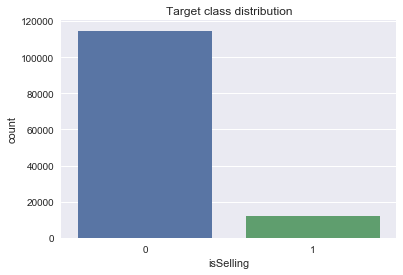

In [12]:
ax = plt.axes()
sns.countplot(x='isSelling', data=vaud_df, ax=ax);
ax.set_title('Target class distribution')
plt.show()

We can see that the target variable is not distributed equally. Our dataset is clearly unbalanced.
It's possible that we will need to perform actions to deal with this unbalanced dataset -> @Raphael


## 4. Feature analysis

### Numerical Feature (continuous and ordinal)

First take a quick look to the statistical information about all the numerical features:


In [13]:
vaud_df.describe(include=[np.number])

,age_avg,age_sd,age_min,age_max,days_since_last_tx,nb_owners,noise_sensibility_level,nb_of_level_in_property,nb_of_unit_in_property,building_sqmt,is_landed,nb_of_rooms,sqmt,taux_hyp,ipc,indice_loyer,isSelling
count,126545.000000,126545.000000,126545.000000,126545.000000,126545.000000,126545.000000,111303.000000,126545.000000,126545.000000,126545.000000,126545.000000,126545.000000,126545.000000,126545.000000,126545.000000,126545.000000,126545.000000
mean,53.804244,1.607183,52.140345,53.927472,1558.262982,1.632494,2.409046,2.870023,3.335738,229.080311,0.680461,4.649081,144.294512,2.814112,0.419022,1.397008,0.094109
std,12.759517,3.289308,13.153281,13.816417,1052.703128,0.835516,0.494920,1.255353,4.486623,273.514652,0.466300,1.543869,73.773248,0.494403,0.844130,0.725852,0.291981
min,2.000000,0.000000,-3.000000,-3.000000,-364.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.850000,-1.100000,0.250000,0.000000
25%,45.000000,0.000000,43.000000,44.000000,730.000000,1.000000,2.000000,2.000000,1.000000,94.000000,0.000000,4.000000,99.000000,2.350000,-0.200000,0.575000,0.000000
50%,53.000000,0.000000,51.000000,53.000000,1460.000000,2.000000,2.000000,3.000000,1.000000,136.000000,1.000000,4.000000,130.000000,2.980000,0.200000,1.300000,0.000000
75%,62.000000,2.000000,60.000000,62.000000,2190.000000,2.000000,3.000000,3.000000,4.000000,259.000000,1.000000,5.000000,172.000000,3.250000,0.800000,2.250000,0.000000
max,194.000000,29.000000,110.000000,327.000000,4519.000000,18.000000,4.000000,19.000000,79.000000,5266.000000,1.000000,19.000000,966.000000,3.460000,2.400000,2.525000,1.000000


At first we can see **some strange or impossible things*** here that will need to be investigate/clean later:
1. The minimum average age of owner is 2 years old and maximum is 194 years old
1. Some age are negative
1. Some owner are 327 years old
1. The minimum days since last transaction is negative
1. Some property has 0 floors or 0 units or 0 m2 or 0 rooms

And some **interesting fact** about the property market in Vaud canton:
1. The average age of owner is about 54 years
1. The average number of owners for a property is less than 2: ~1.63
1. The maximum number of floor is 19 floors but in average a building has about 3 levels.
1. The "average property" in Vaud is a house with 5 rooms and 144 m2
1. The difference of age between owners of the same property is low (single, couple with same age ?)

Now that we have the big picture, let's dig a little bit to explain and analysis feature by feature.

**For each feature we will mainly focus the analysis on the distribution of the feature.**

#### age_avg

Corrrespond to the mean of the age of the owners of the property.

First let us do a scatter plot to see if there are any outliers in the data and then take a look to the distribution of `age_avg`:


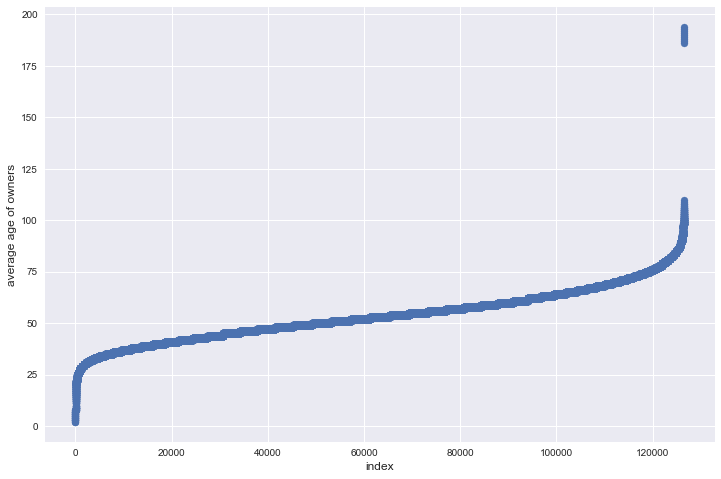

In [14]:
plt.figure(figsize=(12,8))
plt.scatter(range(vaud_df.shape[0]), np.sort(vaud_df.age_avg.values))
plt.xlabel('index', fontsize=12)
plt.ylabel('average age of owners', fontsize=12)
plt.show()

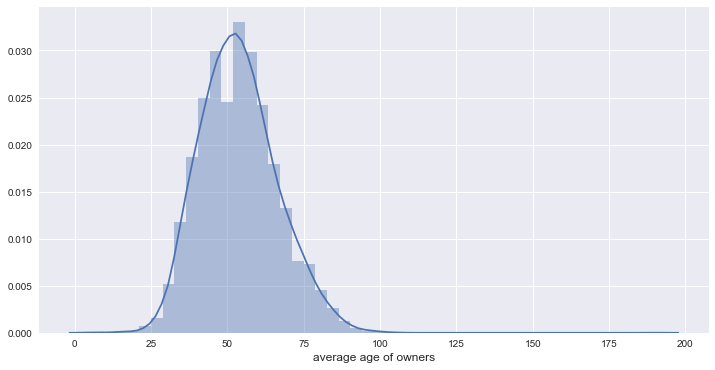

In [15]:
plt.figure(figsize=(12,6))
sns.distplot(vaud_df.age_avg.values)
plt.xlabel('average age of owners', fontsize=12)
plt.show()

If we remove the strange outliers (age about 200 years old...) here is the new distribution of age_avg:

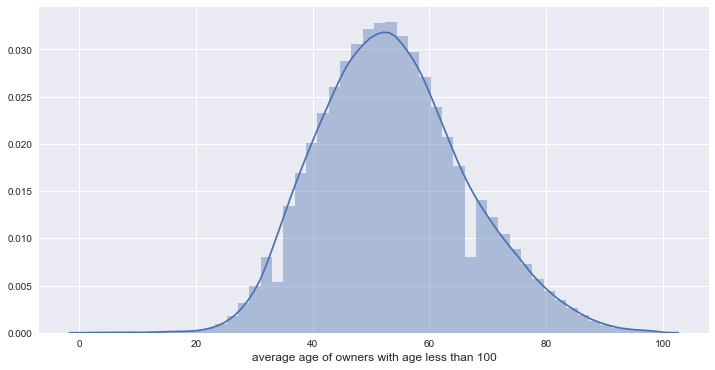

In [16]:
plt.figure(figsize=(12,6))
sns.distplot(vaud_df.age_avg.values[vaud_df.age_avg.values < 100])
plt.xlabel('average age of owners with age less than 100', fontsize=12)
plt.show()

Looks okay to me. The majority of owner are between 40 and 65 years old. Distribution looks like Gaussian with only two stranges missing age at about 35 and 65.
Also one strange things is that some owner are very young, is it for succession and some too old.

**TODO**
Take a look to the data to try to understand the youngest owner and oldest onw. 

No need to modify this feature before using it in the model.


#### age_sd

Corrrespond to the standard deviation of the age of the owners of the property.

First let us do a scatter plot to see if there are any outliers in the data and then take a look to the distribution of `age_sd`:


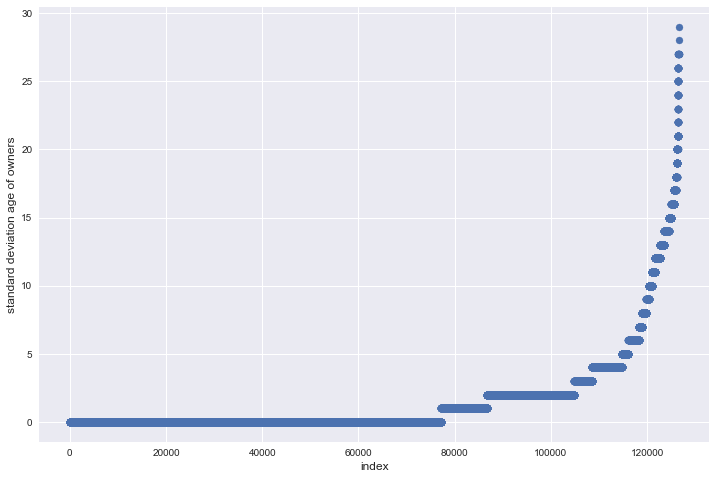

In [17]:
plt.figure(figsize=(12,8))
plt.scatter(range(vaud_df.shape[0]), np.sort(vaud_df.age_sd.values))
plt.xlabel('index', fontsize=12)
plt.ylabel('standard deviation age of owners', fontsize=12)
plt.show()

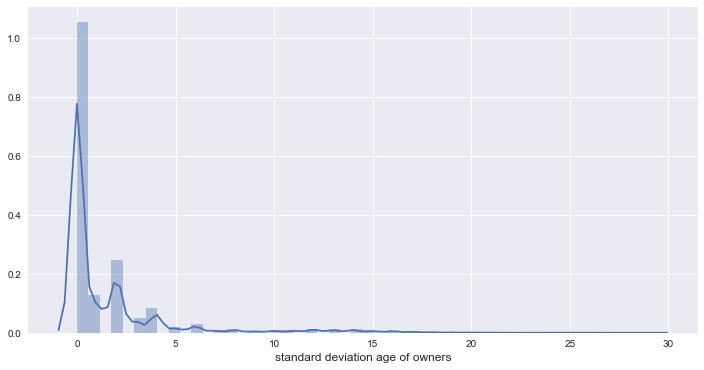

In [18]:
plt.figure(figsize=(12,6))
sns.distplot(vaud_df.age_sd.values)
plt.xlabel('standard deviation age of owners', fontsize=12)
plt.show()

Here we clearly see that our features doesn't follow a normal distribution and has a very long right tail.
The reason why we have so many value equal to 0 is that when we have only one owner, the standard deviation is consequently equal to 0 as we have only one value.

In the scatter we can see that this feature looks like more an ordinal value than a continuous value.
By using a countplot we can clearly see that the dominant variable is equal to 0 and after 6 we got only few number:


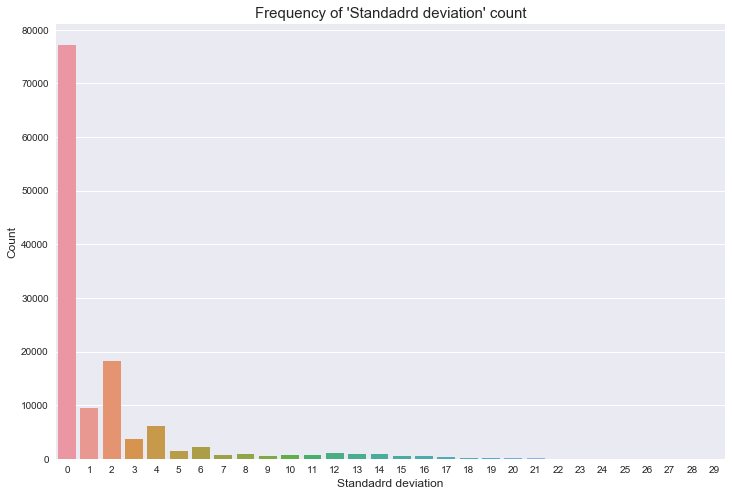

In [19]:
plt.figure(figsize=(12,8))
sns.countplot(x="age_sd", data=vaud_df)
plt.ylabel('Count', fontsize=12)
plt.xlabel('Standadrd deviation', fontsize=12)
plt.title("Frequency of 'Standadrd deviation' count", fontsize=15)
plt.show()

**TODO**
How to manage this kind of feature that have dominant value (here mainly 0) ? Will be better to do not round the standard deviation during the ETL process ? -> @Raphael
Do we need to keep this feature ? Or modify it ? Or removing the data with too huge standard deviation ?

#### age_min

Corrrespond to the age of the youngest owner of the property:


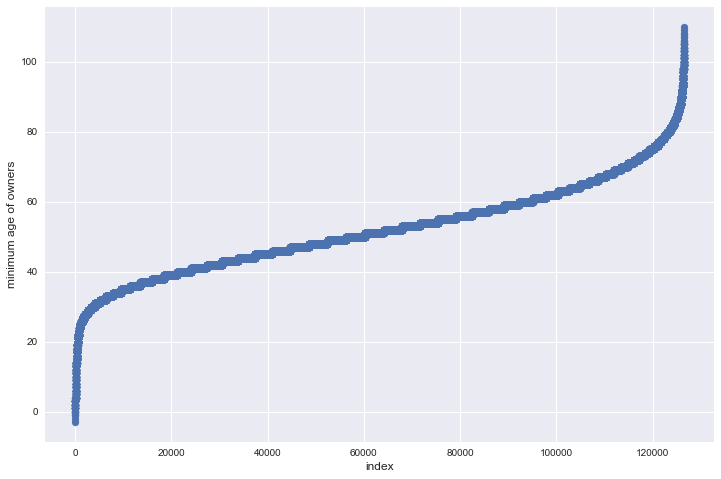

In [20]:
plt.figure(figsize=(12,8))
plt.scatter(range(vaud_df.shape[0]), np.sort(vaud_df.age_min.values))
plt.xlabel('index', fontsize=12)
plt.ylabel('minimum age of owners', fontsize=12)
plt.show()

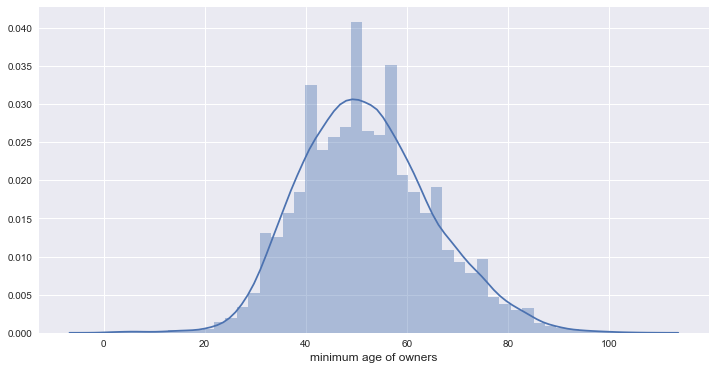

In [21]:
plt.figure(figsize=(12,6))
sns.distplot(vaud_df.age_min.values)
plt.xlabel('minimum age of owners', fontsize=12)
plt.show()

Our feature follow a normal distribution.
We see in the scatter plot that it seems that we are negative value.

Let's display them:


In [22]:
negative_age_min = vaud_df.age_min.values[vaud_df.age_min.values < 0]
negative_age_min

array([-1, -2, -3, -1])

**TODO**: Like for age_avg we need to understand these negative value for age -> Thibault

#### age_max

Corrrespond to the age of the oldest owners of the property.



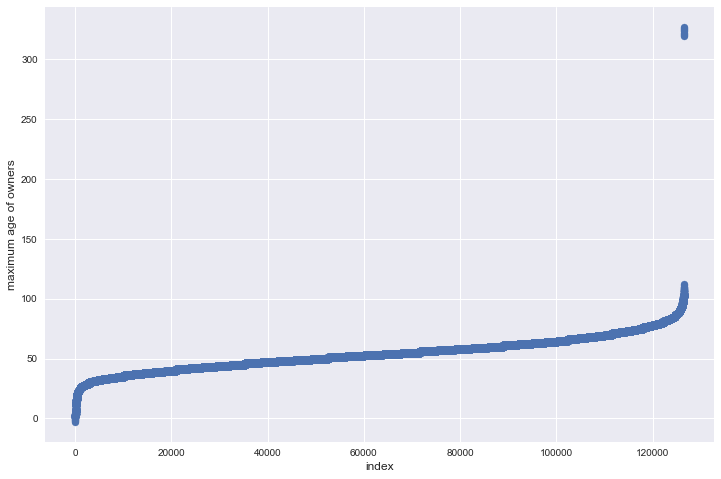

In [23]:
plt.figure(figsize=(12,8))
plt.scatter(range(vaud_df.shape[0]), np.sort(vaud_df.age_max.values))
plt.xlabel('index', fontsize=12)
plt.ylabel('maximum age of owners', fontsize=12)
plt.show()

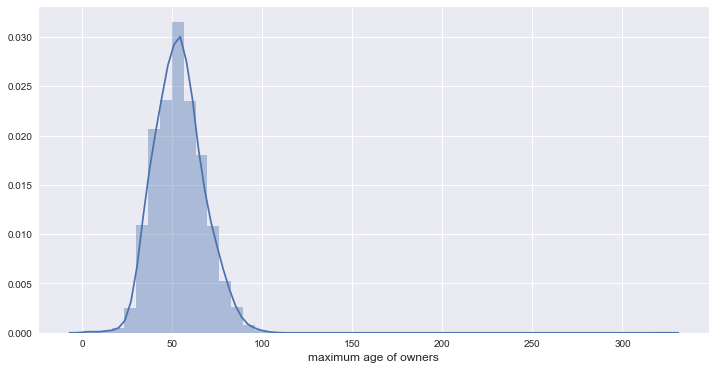

In [24]:
plt.figure(figsize=(12,6))
sns.distplot(vaud_df.age_max.values)
plt.xlabel('maximum age of owners', fontsize=12)
plt.show()

Same that for age_avg. If we remove the outlier (too old to be true), this feature follow a gaussian distribution:


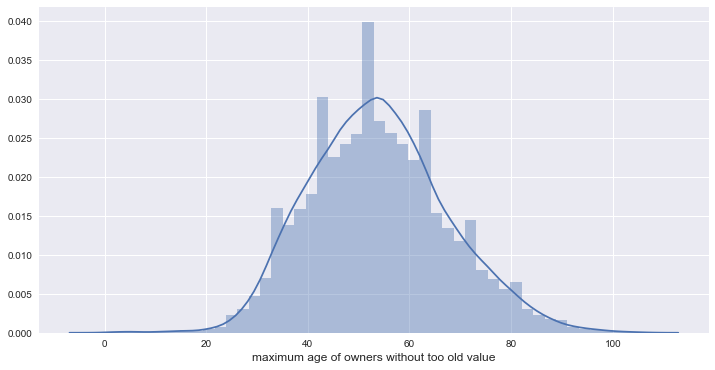

In [25]:
plt.figure(figsize=(12,6))
sns.distplot(vaud_df.age_max.values[vaud_df.age_max.values < 110])
plt.xlabel('maximum age of owners without too old value', fontsize=12)
plt.show()

Looks better.

#### days_since_last_tx

Corrrespond to the number of days since the owner(s) own this property.


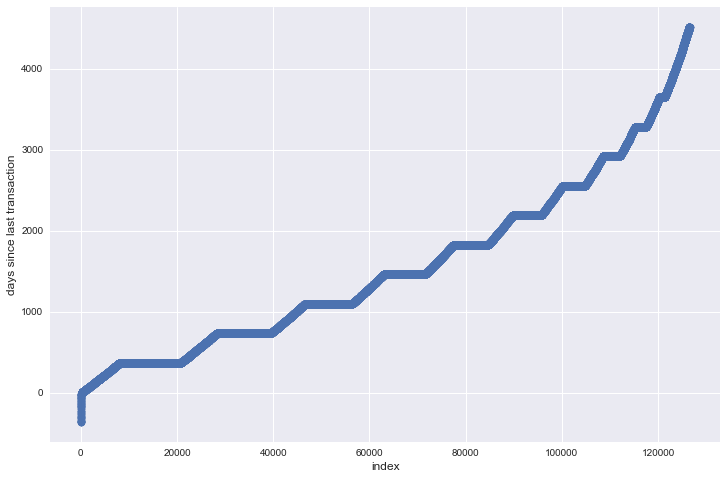

In [26]:
plt.figure(figsize=(12,8))
plt.scatter(range(vaud_df.shape[0]), np.sort(vaud_df.days_since_last_tx.values))
plt.xlabel('index', fontsize=12)
plt.ylabel('days since last transaction', fontsize=12)
plt.show()

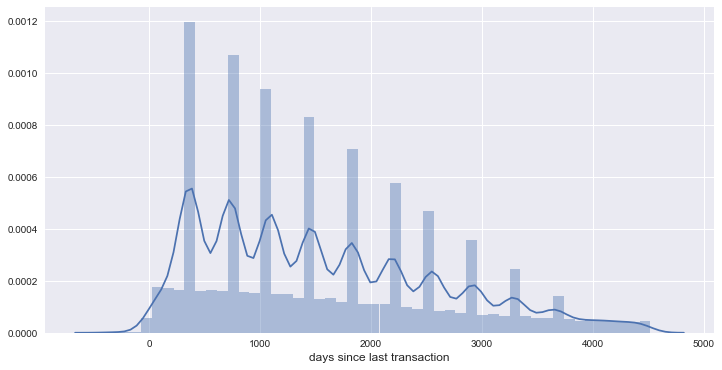

In [27]:
plt.figure(figsize=(12,6))
sns.distplot(vaud_df.days_since_last_tx.values)
plt.xlabel('days since last transaction', fontsize=12)
plt.show()

First, we see that the days since last transaction is decreasing as expecting. 

Secondly what is this "frequent high count" for some value ? This is the result of how the past dataset has been created. This high value represent multiple of 365 (1 year). I don't think to having continuous value wity frequent high count of same value compare to other value can be a problem for our model -> Check with @Raphael

In [28]:
# plt.figure(figsize=(12,4))
# #vaud_df["isSelling"] = vaud_df["isSelling"].astype('category')
# sns.boxplot(x='days_since_last_tx', y='isSelling', data=vaud_df, showmeans=True)
# plt.show()

#### nb_owners

Corrrespond to the number of owner(s) that own the property.


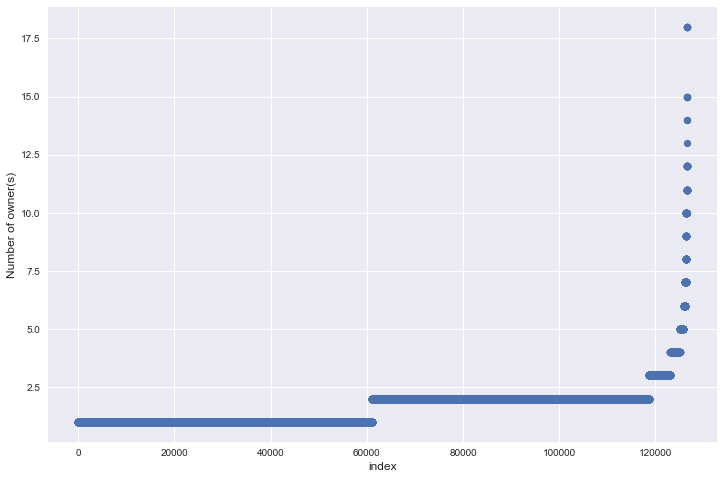

In [29]:
plt.figure(figsize=(12,8))
plt.scatter(range(vaud_df.shape[0]), np.sort(vaud_df.nb_owners.values))
plt.xlabel('index', fontsize=12)
plt.ylabel('Number of owner(s)', fontsize=12)
plt.show()

It seems that we have an ordinal feature here
Let's display it using a coutplot chart:

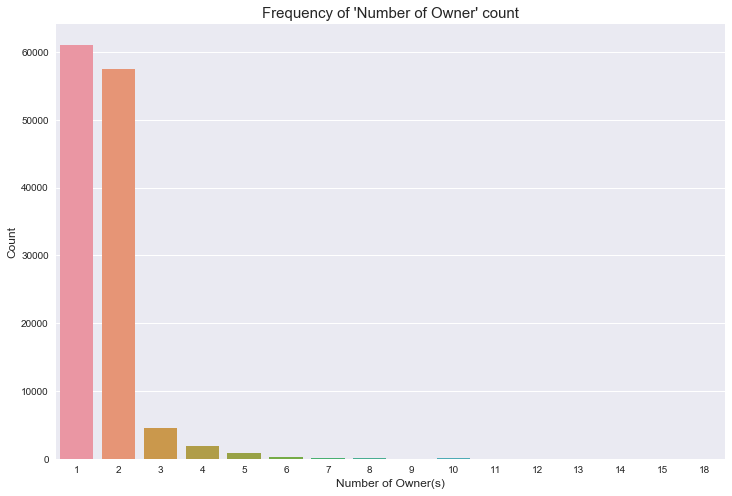

In [30]:
plt.figure(figsize=(12,8))
sns.countplot(x="nb_owners", data=vaud_df)
plt.ylabel('Count', fontsize=12)
plt.xlabel('Number of Owner(s)', fontsize=12)
plt.title("Frequency of 'Number of Owner' count", fontsize=15)
plt.show()

And display the excact count for each "Number of owner(s)":

In [31]:
vaud_df.nb_owners.value_counts()

1     61114
2     57532
3      4485
4      1894
5       820
6       328
7       153
10       59
8        51
9        35
11       33
12       25
18        8
15        5
14        2
13        1
Name: nb_owners, dtype: int64

Clearly we have 1 and 2 owners that is over represented compare to others. Also after 7 "Number of owner(s)", the count is very small, less than 100 for each.

**Todo**
Do we need to remove the rows with too many owners has it could pollute the feature ? -> @Raphael


#### noise_sensibility_level

Corrrespond to noise sensibility level in the area of the property.

Do not forget that for this feature we have some missing values.

First let us do a scatter plot to see if there are any outliers in the data and then take a look to the distribution of `noise_sensibility_level`:


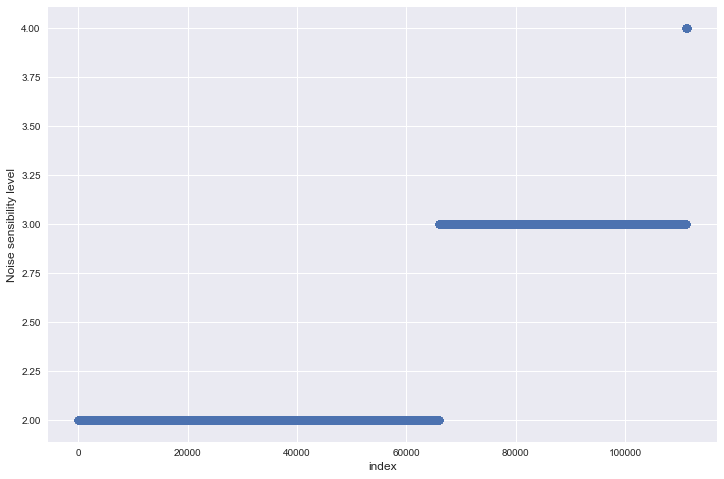

In [32]:
plt.figure(figsize=(12,8))
plt.scatter(range(vaud_df.shape[0]), np.sort(vaud_df.noise_sensibility_level.values))
plt.xlabel('index', fontsize=12)
plt.ylabel('Noise sensibility level', fontsize=12)
plt.show()

Clearly we have an ordinal feature here.
Let's display it using a countplot chart:

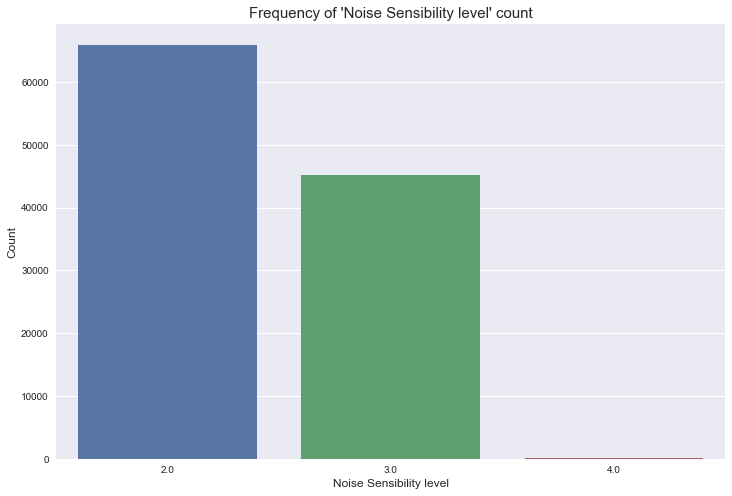

In [33]:
plt.figure(figsize=(12,8))
sns.countplot(x="noise_sensibility_level", data=vaud_df)
plt.ylabel('Count', fontsize=12)
plt.xlabel('Noise Sensibility level', fontsize=12)
plt.title("Frequency of 'Noise Sensibility level' count", fontsize=15)
plt.show()

Do not forget that for this feature we have missing values (NaN):

In [34]:
vaud_df.noise_sensibility_level.unique()

array([  2.,   3.,  nan,   4.])

We see that 2 and 3 is recurrent value when a level of 4 is very rare.

**Todo**
What do we do with missing value ? Nothing or we try to replace them by random on or use another model to fill them ? -> @Raphael


#### nb_of_level_in_property

Corrrespond to the number of floor in the building. If the property is in a building with other units (appartment), the nb_of_level_in_property correspond to the number of levels of the entire building and not only the unit.


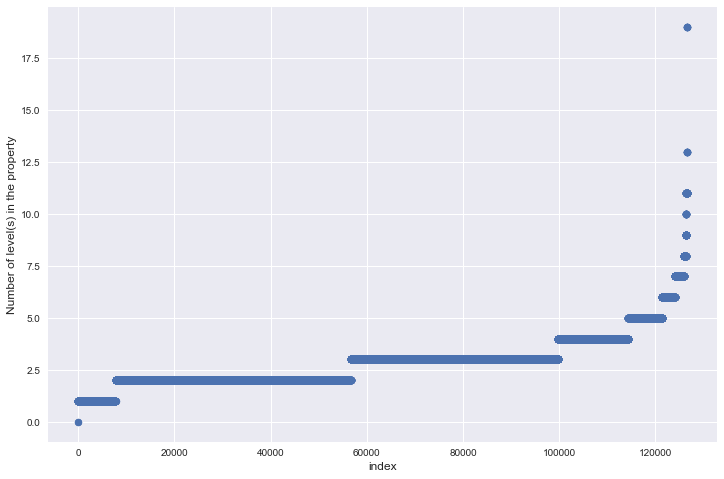

In [35]:
plt.figure(figsize=(12,8))
plt.scatter(range(vaud_df.shape[0]), np.sort(vaud_df.nb_of_level_in_property.values))
plt.xlabel('index', fontsize=12)
plt.ylabel('Number of level(s) in the property', fontsize=12)
plt.show()

We have an ordinal feature here so let's display it using a countplot chart:

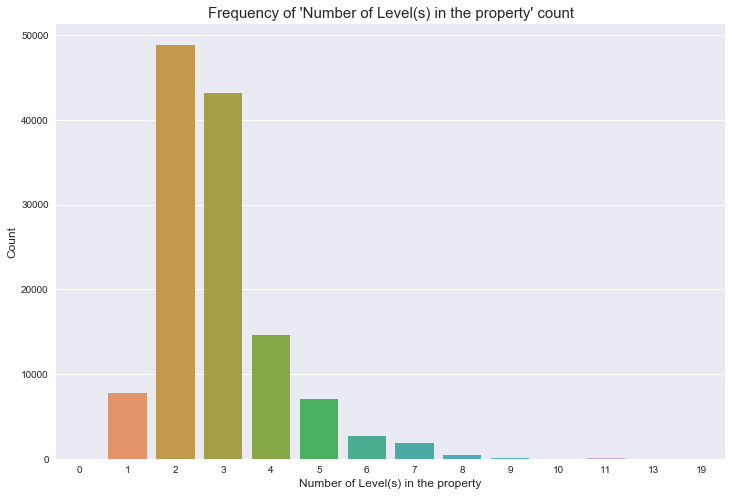

In [36]:
plt.figure(figsize=(12,8))
sns.countplot(x="nb_of_level_in_property", data=vaud_df)
plt.ylabel('Count', fontsize=12)
plt.xlabel('Number of Level(s) in the property', fontsize=12)
plt.title("Frequency of 'Number of Level(s) in the property' count", fontsize=15)
plt.show()

Everyhting normal here.


**Todo**
Do we need to remove the rows with too many owners has it could pollute the feature ? -> @Raphael


#### nb_of_unit_in_property

Corrrespond to the number of unit in the plot. If the unit is in a building with other units (flat), the nb_of_unit_in_property correspond to the number of units in the entire building. If this unit is a house, nb_of_unit_in_property will be equal to one.

First let us do a scatter plot to see if there are any outliers in the data and then take a look to the distribution of `nb_of_unit_in_property`:


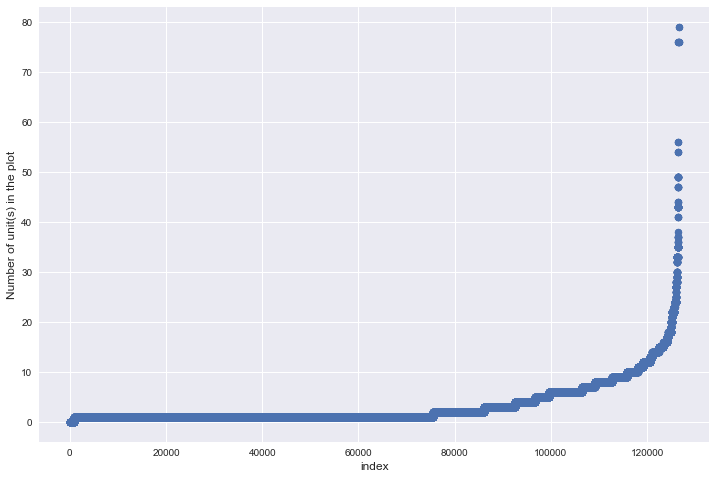

In [37]:
plt.figure(figsize=(12,8))
plt.scatter(range(vaud_df.shape[0]), np.sort(vaud_df.nb_of_unit_in_property.values))
plt.xlabel('index', fontsize=12)
plt.ylabel('Number of unit(s) in the plot', fontsize=12)
plt.show()

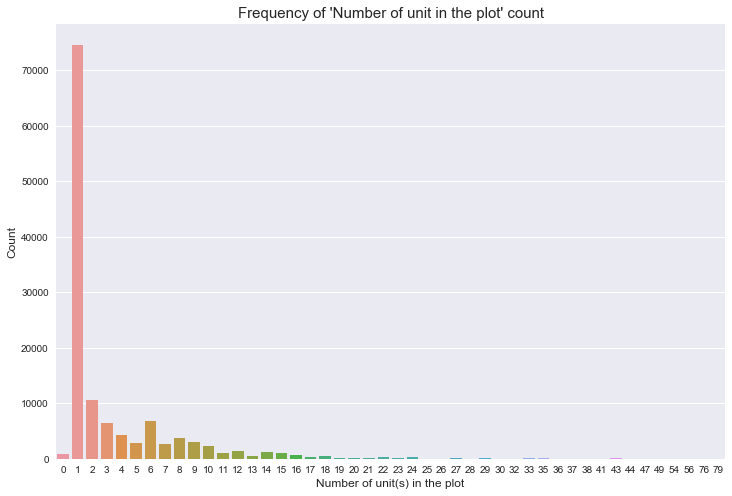

In [38]:
plt.figure(figsize=(12,8))
sns.countplot(x="nb_of_unit_in_property", data=vaud_df)
plt.ylabel('Count', fontsize=12)
plt.xlabel('Number of unit(s) in the plot', fontsize=12)
plt.title("Frequency of 'Number of unit in the plot' count", fontsize=15)
plt.show()

Everyhting normal here, we clearly have a majority of house (nb of unit equal to 1).

**Todo**
Do we need to remove the rows with too many owners has it could pollute the feature ? -> @Raphael


#### building_sqmt

Surface of the base of the building (**TODO**: better check this and also the need of this feature-> @Thibault). In case the unit is a house it corresponds to the base surface of the unit. In case the unit is a flat it correspond to the base surface of the entire building.


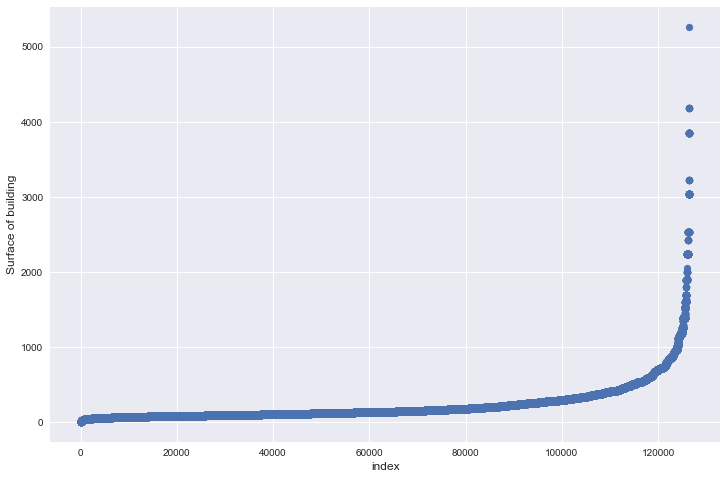

In [39]:
plt.figure(figsize=(12,8))
plt.scatter(range(vaud_df.shape[0]), np.sort(vaud_df.building_sqmt.values))
plt.xlabel('index', fontsize=12)
plt.ylabel('Surface of building', fontsize=12)
plt.show()

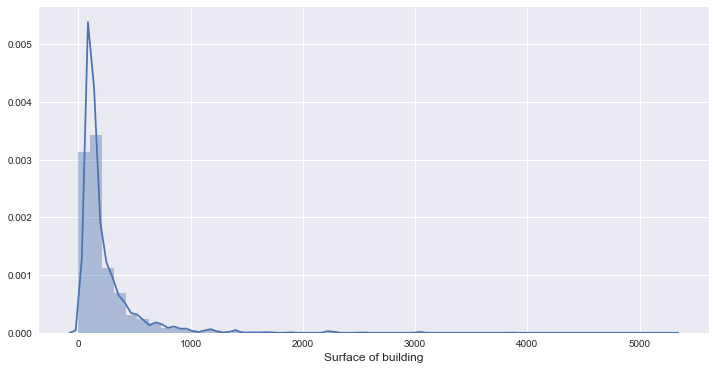

In [40]:
plt.figure(figsize=(12,6))
sns.distplot(vaud_df.building_sqmt.values)
plt.xlabel('Surface of building', fontsize=12)
plt.show()

Here we see a a very long right tail. Let us plot the log of sqmt variable to check if the feature is following a log normal distribution instead:

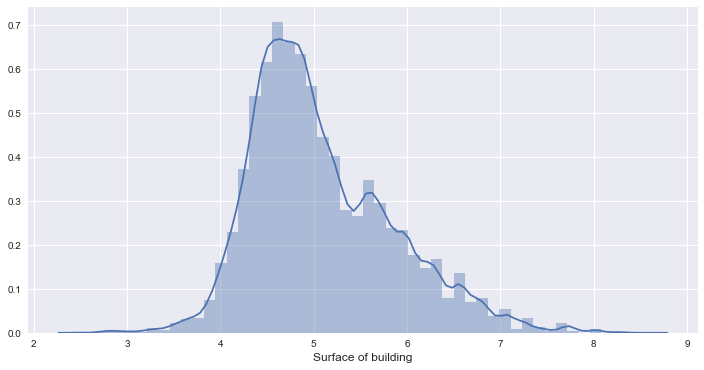

In [41]:
plt.figure(figsize=(12,6))
sns.distplot(np.log(vaud_df.building_sqmt.values[vaud_df.building_sqmt.values > 0]))
plt.xlabel('Surface of building', fontsize=12)
plt.show()

That's look better.

**TODO**
Add a new feature that is the log of building_sqmt.

#### is_landed

It's a boolean indicating if a unit is a house (=1) or an appartment (=0). 
This feature has been constructed with the nb_of_unit_in_property. In the case of nb_of_unit_in_property is <= 2 so we consider that this unit is an house. Why = 2 ? Because when a plot is composed of only 2 units is in the majority of case a semi-detached house.


It seems that we have an ordinal feature here
Let's display it using a coutplot chart:

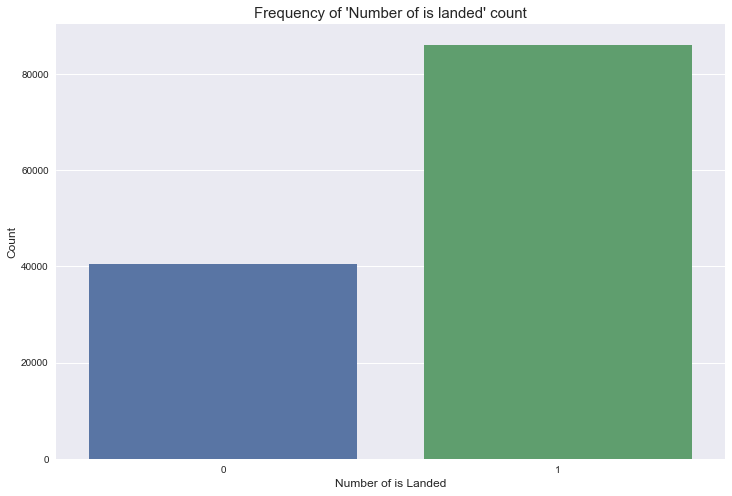

In [42]:
plt.figure(figsize=(12,8))
sns.countplot(x="is_landed", data=vaud_df)
plt.ylabel('Count', fontsize=12)
plt.xlabel('Number of is Landed', fontsize=12)
plt.title("Frequency of 'Number of is landed' count", fontsize=15)
plt.show()

Everything normal here. We see that we have more house than appartment.

#### nb_of_rooms

Corrrespond to the number of rooms in the unit. 

For no-landed-house unit, it was not possible to get the exact number of bedrooms. After analyzing some sample we saw that the majority of building in Vaud are composed of units with a similar size. In other words it's very rare to see in the same building a 8 rooms appartment and also a 2 rooms appartment.
For instance in Lausanne the average a plot with more than one house is composed of 12,11 units, with a standard deviation of the numbers of rooms of 0,66 and a standadard deviation of the surface in square meters of 17,43.
For Switzerland the number are: 5.5360 units, 0.6337 standard deviation of the numbers of rooms, 19.2246 standadard deviation of the surface in square meters.

Consequently for no-landed house the nb_of_rooms equal to the rounded value of the average number of rooms of all the unit in the building. 

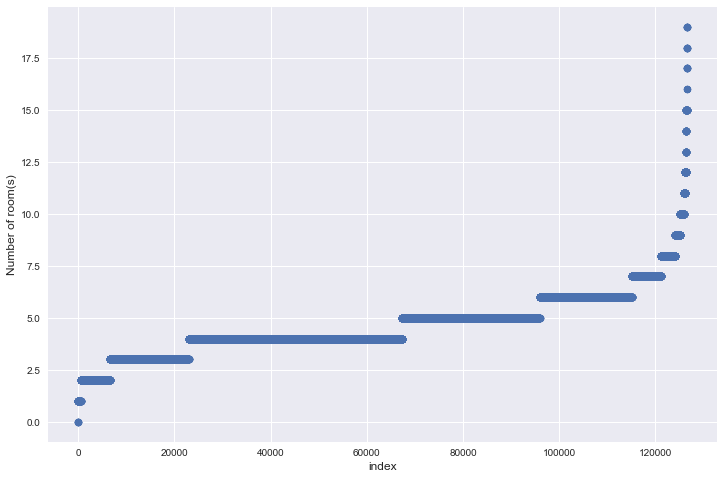

In [43]:
plt.figure(figsize=(12,8))
plt.scatter(range(vaud_df.shape[0]), np.sort(vaud_df.nb_of_rooms.values))
plt.xlabel('index', fontsize=12)
plt.ylabel('Number of room(s)', fontsize=12)
plt.show()

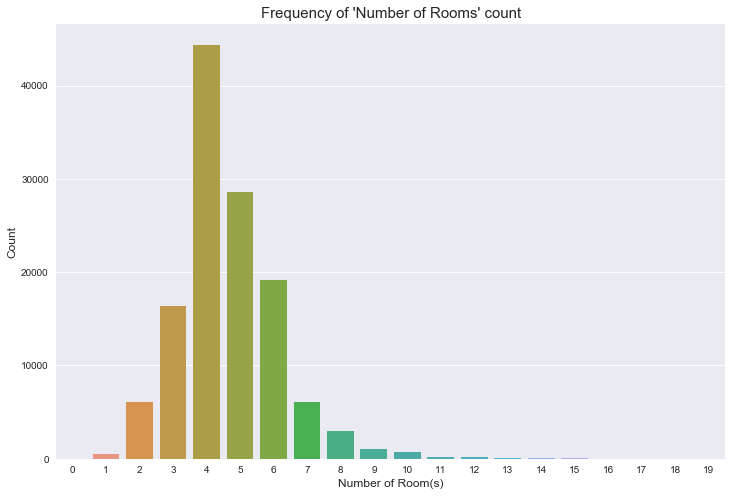

In [44]:
plt.figure(figsize=(12,8))
sns.countplot(x="nb_of_rooms", data=vaud_df)
plt.ylabel('Count', fontsize=12)
plt.xlabel('Number of Room(s)', fontsize=12)
plt.title("Frequency of 'Number of Rooms' count", fontsize=15)
plt.show()


Looks ok.

**Todo**
Do we need to remove the rows with too many owners has it could pollute the feature ? -> @Raphael


#### sqmt

Surface of the unit.

For no-landed-house unit, it was not possible to get the exact surface of a specific unit, so the sqmt is equal to the average of the sqmt of all units in this building. For more explanation read the part above about nb_of_rooms.


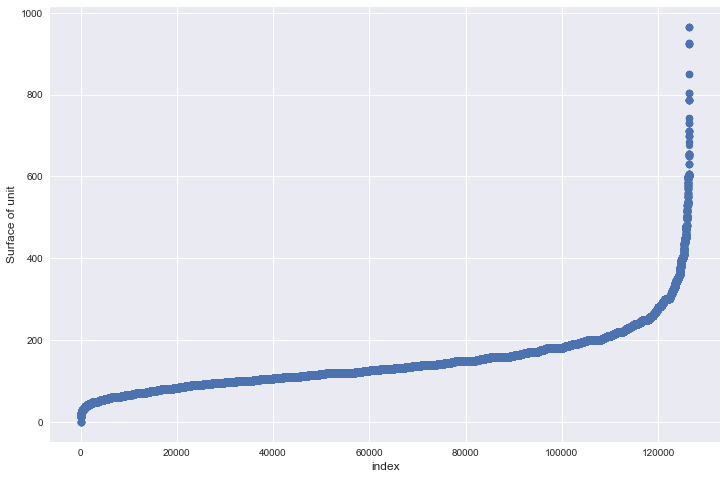

In [45]:
plt.figure(figsize=(12,8))
plt.scatter(range(vaud_df.shape[0]), np.sort(vaud_df.sqmt.values))
plt.xlabel('index', fontsize=12)
plt.ylabel('Surface of unit', fontsize=12)
plt.show()

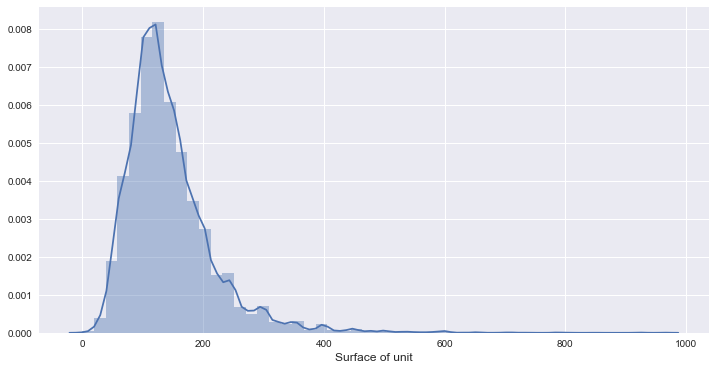

In [46]:
plt.figure(figsize=(12,6))
sns.distplot(vaud_df.sqmt.values)
plt.xlabel('Surface of unit', fontsize=12)
plt.show()

Here we see a a very long right tail. Let us plot the log of sqmt variable to check if the feature is following a log normal distribution instead:

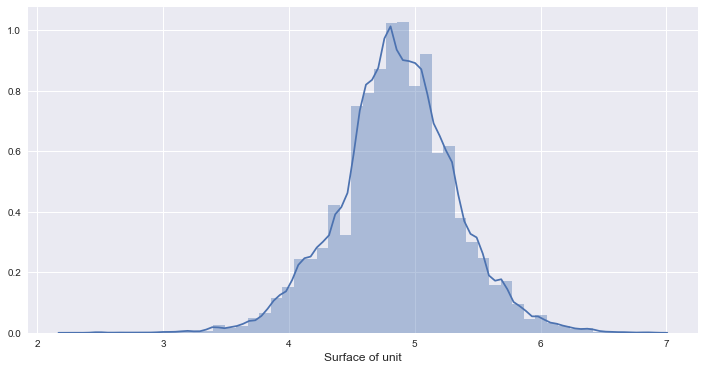

In [47]:
plt.figure(figsize=(12,6))
sns.distplot(np.log(vaud_df.sqmt.values[vaud_df.sqmt.values > 0]))
plt.xlabel('Surface of unit', fontsize=12)
plt.show()

That's look better.

**TODO**
Add a new feature that is the log of sqmt.

#### taux_hyp

Mortgage rate the year before. 
In others word is a row have a date of 2005-05-05, the value of taux_hyp will be equal to the mortgage rate in 2004. 


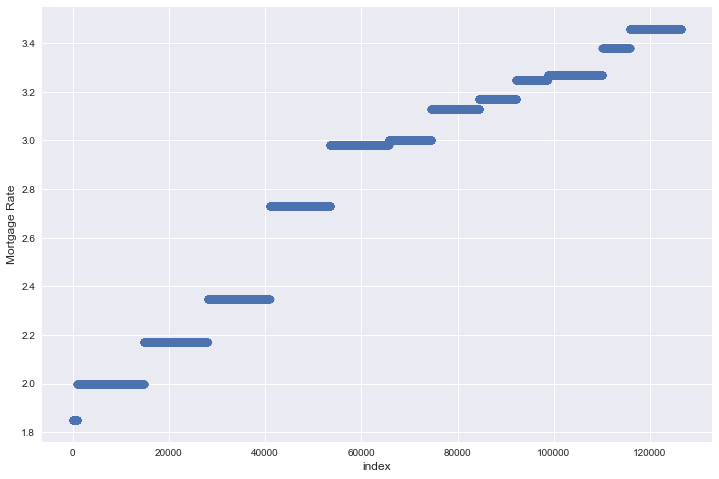

In [48]:
plt.figure(figsize=(12,8))
plt.scatter(range(vaud_df.shape[0]), np.sort(vaud_df.taux_hyp.values))
plt.xlabel('index', fontsize=12)
plt.ylabel('Mortgage Rate', fontsize=12)
plt.show()

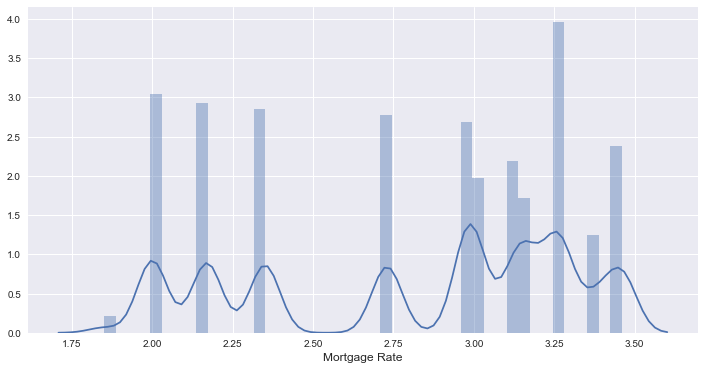

In [49]:
plt.figure(figsize=(12,6))
sns.distplot(vaud_df.taux_hyp.values)
plt.xlabel('Mortgage Rate', fontsize=12)
plt.show()

**TODO**
In the next dataset version it could be interesting to be more fine grain about the pick of the mortgage rate. For instance:
* Take the value of the month of the inception date
* Add more feature like: 1 year Before, 6 months before, 1 month before

#### ipc

Evolution of the consumer price index ("Indice des prix a la consomation") the year before. 


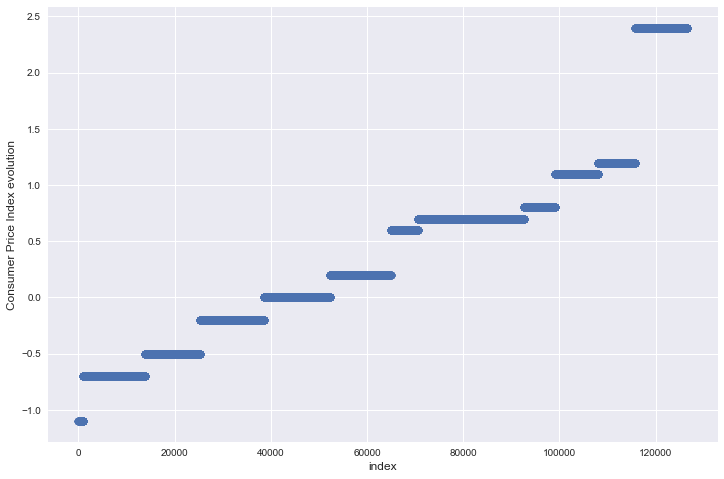

In [50]:
plt.figure(figsize=(12,8))
plt.scatter(range(vaud_df.shape[0]), np.sort(vaud_df.ipc.values))
plt.xlabel('index', fontsize=12)
plt.ylabel('Consumer Price Index evolution', fontsize=12)
plt.show()

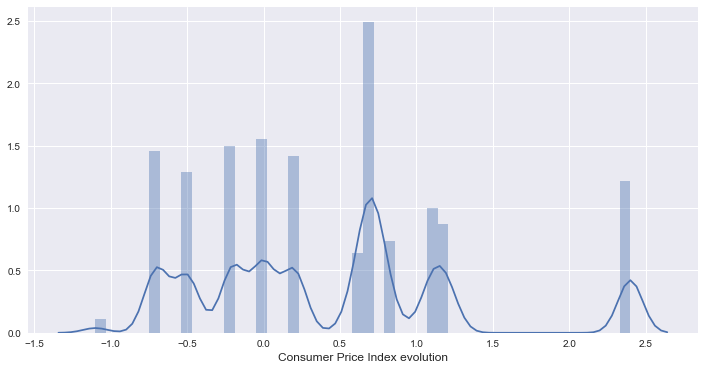

In [51]:
plt.figure(figsize=(12,6))
sns.distplot(vaud_df.ipc.values)
plt.xlabel('Consumer Price Index evolution', fontsize=12)
plt.show()

Same comment as mortgage rate.

#### indice_loyer

Evolution of the renting index the year before.


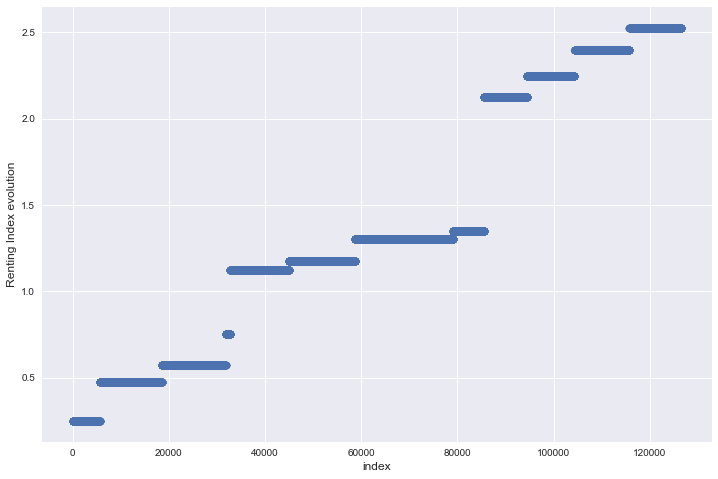

In [52]:
plt.figure(figsize=(12,8))
plt.scatter(range(vaud_df.shape[0]), np.sort(vaud_df.indice_loyer.values))
plt.xlabel('index', fontsize=12)
plt.ylabel('Renting Index evolution', fontsize=12)
plt.show()

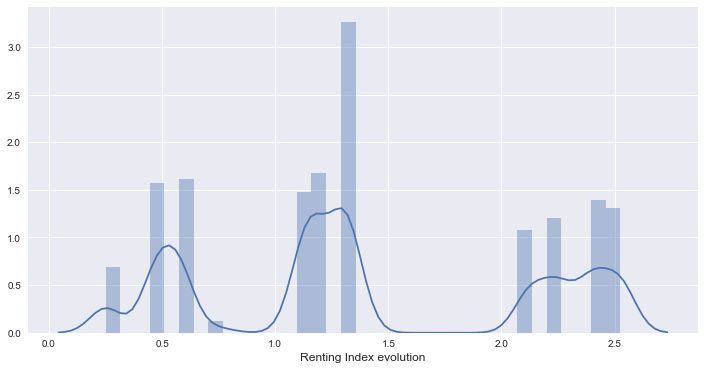

In [53]:
plt.figure(figsize=(12,6))
sns.distplot(vaud_df.indice_loyer.values)
plt.xlabel('Renting Index evolution', fontsize=12)
plt.show()

Same comment as mortgage rate.

### Categorical Feature

First take a quick look to the information about all the categorical features:


In [54]:
vaud_df.describe(include=[np.object])

,reason_last_tx,parcelle_type,amenagement_type
count,82041,126545,126545
unique,14,8,30
top,Achat,B-F,Zone d'habitation de très faible densité
freq,80403,68865,55908


Some **interesting fact** about the property market in Vaud canton:
1. Majority of people live in an area with low level of population density (~)
1. Majority of Plot is B-F for "Bien Fonds" (~50%)
1. Majority of reason of last transaction is Achat

Now that we have the big picture, let's dig a little bit to explain and analysis feature by feature:


#### reason_last_tx

Reason of the last transaction, or how the current owners take possession of this property.

As it's a categorical feature, first let us do a count plot `reason_last_tx` 

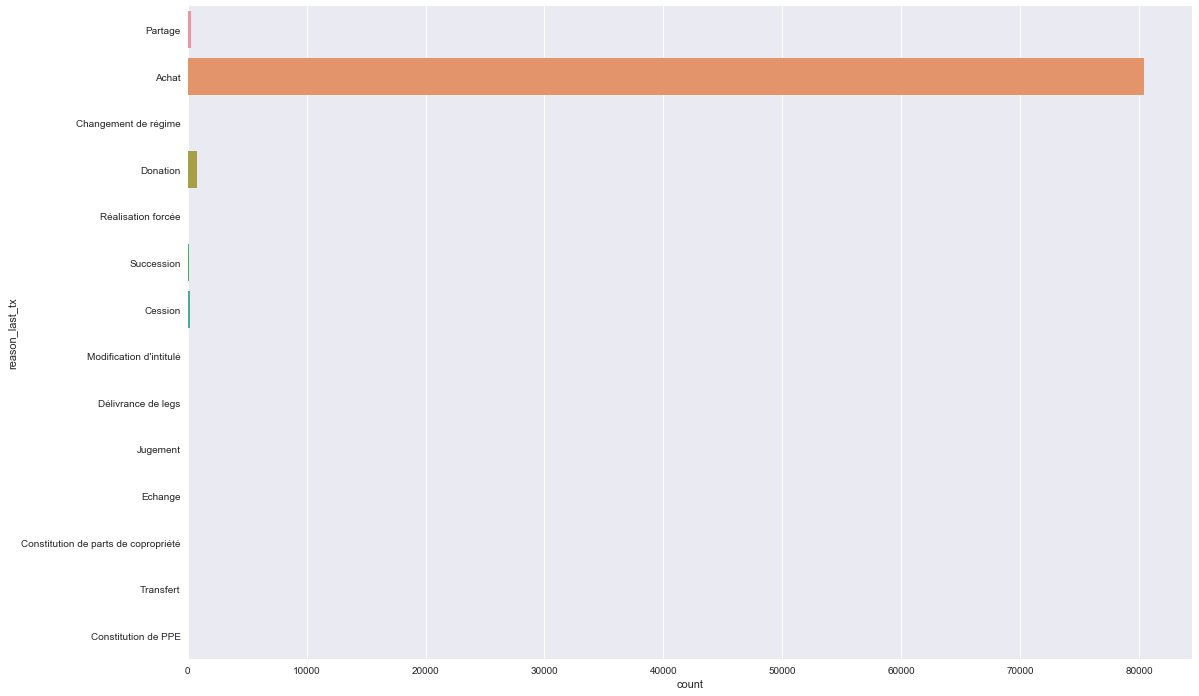

In [55]:
plt.figure(figsize=(18,12))
sns.countplot(y="reason_last_tx", data=vaud_df);
plt.show()

Let's list the count for each reason in descending order to get the exact number:

In [56]:
vaud_df.reason_last_tx.value_counts()

Achat                                   80403
Donation                                  798
Partage                                   251
Cession                                   228
Succession                                122
Echange                                    63
Réalisation forcée                         41
Transfert                                  36
Jugement                                   33
Délivrance de legs                         23
Modification d'intitulé                    18
Constitution de parts de copropriété        9
Constitution de PPE                         8
Changement de régime                        8
Name: reason_last_tx, dtype: int64

Clearly the main reason is 'Achat' and that represent about 98% of the total of not missing value. Remember also that that we have about 35% of missing value for this feature.

#### parcelle_type

Type of the parcelle ownership (for instance co-ownership).


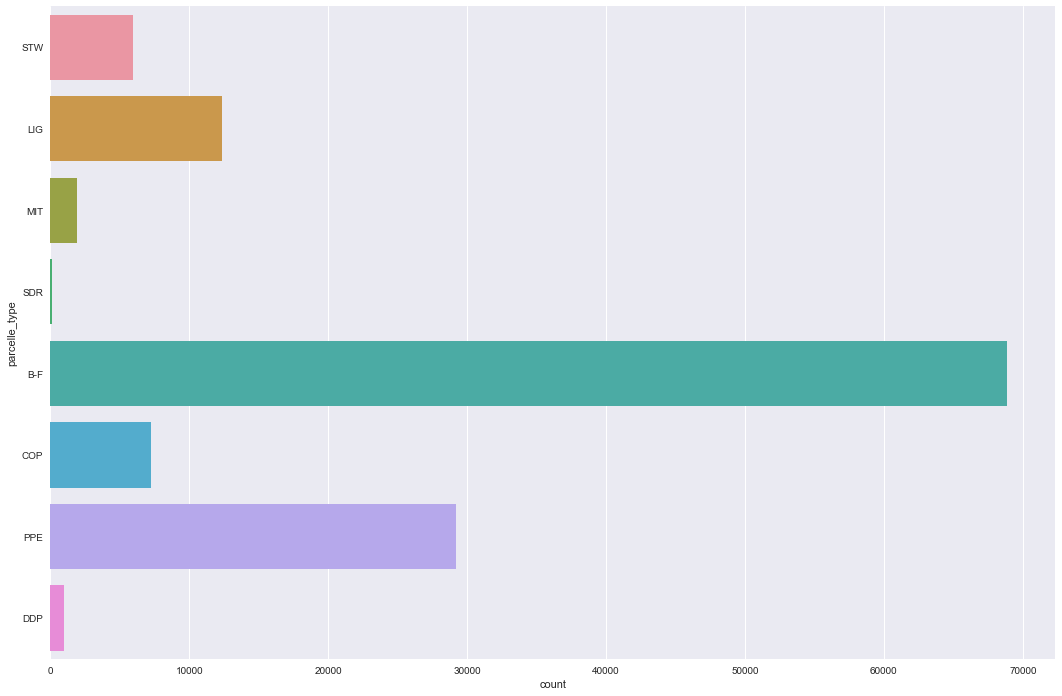

In [57]:
plt.figure(figsize=(18,12))
sns.countplot(y="parcelle_type", data=vaud_df);
plt.show()

Let's list the count for each parcelle type in descending order:

In [58]:
vaud_df.parcelle_type.value_counts()

B-F    68865
PPE    29226
LIG    12315
COP     7250
STW     5909
MIT     1933
DDP      948
SDR       99
Name: parcelle_type, dtype: int64

In fact **we should have only 4 different type**: 
* LIG is the german name for B-F
* STW is the german name for PPE
* MIT is the german name for COP
* SDR is the german name for DDP

So we need to clean them on the ETL process -> @Thibault

#### amenagement_type

Type of zone where is the property.

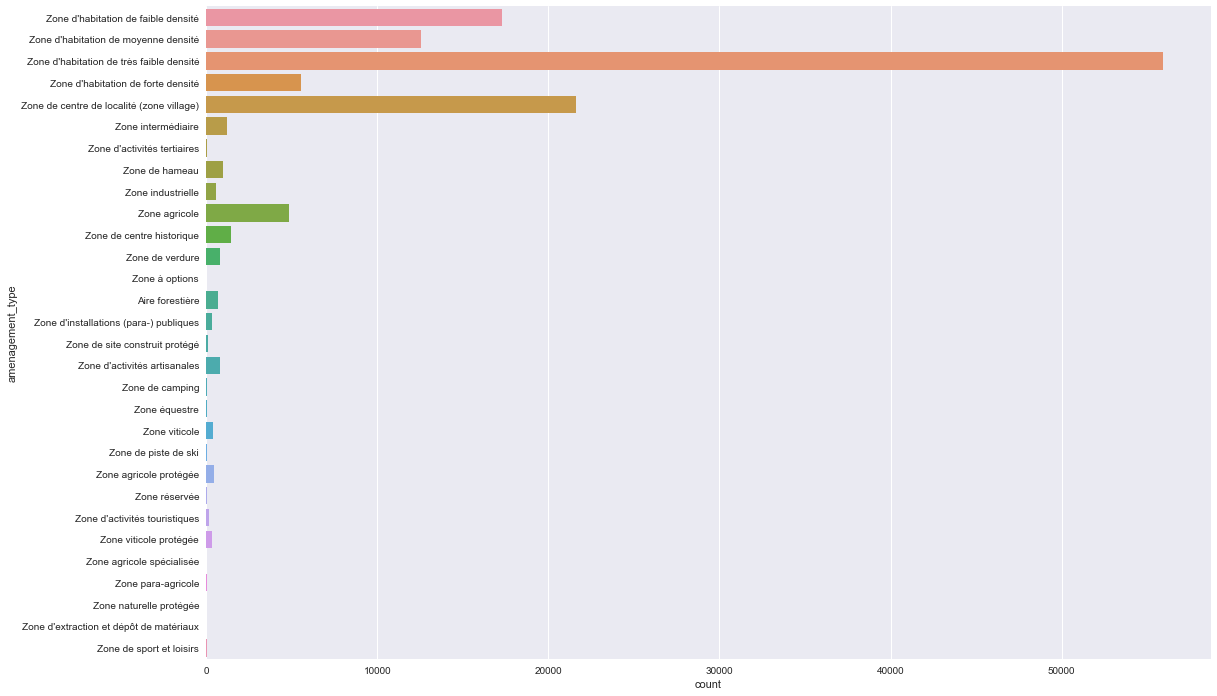

In [59]:
plt.figure(figsize=(18,12))
sns.countplot(y="amenagement_type", data=vaud_df);
plt.show()

Let's list the count for each zone in descending order:

In [60]:
vaud_df.amenagement_type.value_counts()

Zone d'habitation de très faible densité     55908
Zone de centre de localité (zone village)    21641
Zone d'habitation de faible densité          17272
Zone d'habitation de moyenne densité         12585
Zone d'habitation de forte densité            5556
Zone agricole                                 4869
Zone de centre historique                     1470
Zone intermédiaire                            1225
Zone de hameau                                 995
Zone de verdure                                786
Zone d'activités artisanales                   782
Aire forestière                                711
Zone industrielle                              580
Zone agricole protégée                         473
Zone viticole                                  408
Zone d'installations (para-) publiques         341
Zone viticole protégée                         329
Zone d'activités touristiques                  163
Zone de site construit protégé                  85
Zone d'activités tertiaires    

Majority of zone is kind of "Zone d'habitation" that is normal. Some others zone are a little bit strange like "Zone de piste de ski".

**TODO**
Is it ok to keep all this category or would be better to regroup the not well represented category to a new category "other" ? -> @Raphael

## Variable Correlation

Let's do a Variable Correlation Map to try to find correlation between variables:


In [61]:
vaud_df = vaud_df.drop(['isSelling'], axis=1)

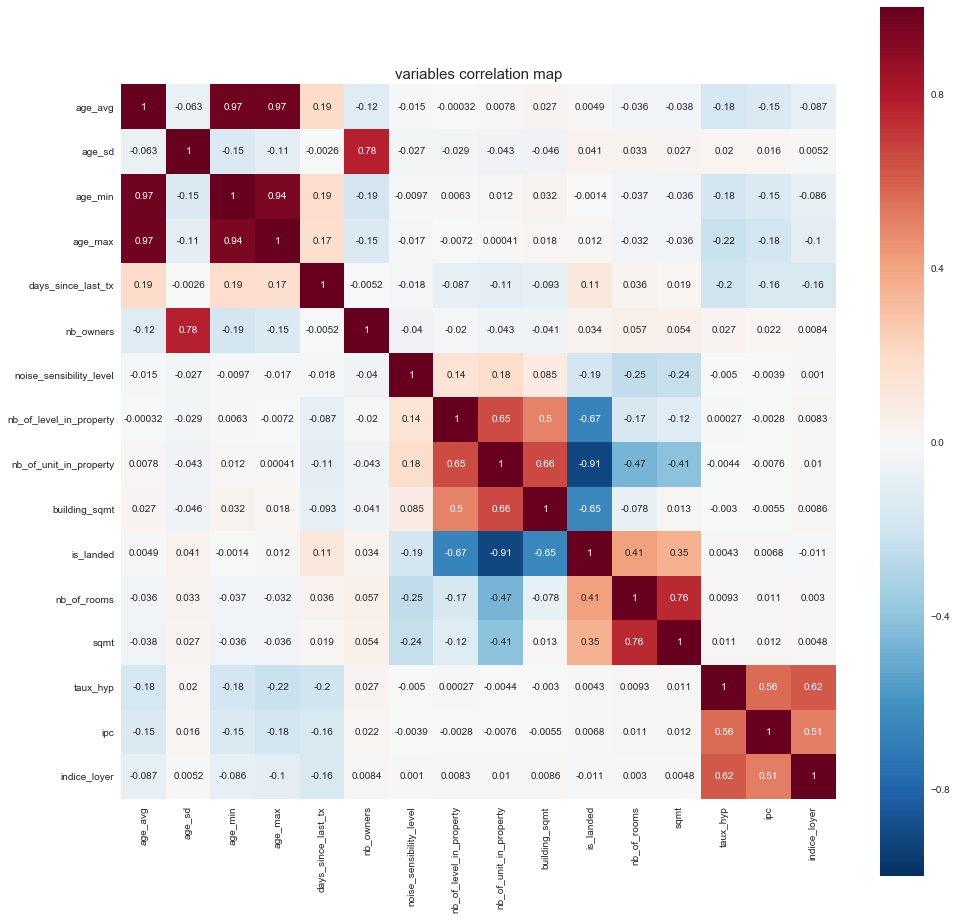

In [62]:
f, ax = plt.subplots(figsize=(16, 16))

# Draw the heatmap using seaborn
sns.heatmap(vaud_df.corr(method='spearman'), square=True, annot=True)
# sns.heatmap(vaud_df.corr(), square=True, annot=True)
plt.title("variables correlation map", fontsize=15)
plt.show()

Interesting fact that we can extract from this map correlation map:
* As expected, age_avg, age_min and age_max are highly correlated
* age_sd and nb_owners are highly correlated: more owner we are, more chance that the standard deviation rise
* The number of rooms and unit is respectively correlated to the surface of the unit or surface of the building
* All the macro economic feature are correlated

Strange fact:
* The isLanded feature is not correlated to the nb_of_unit_in_property. Strange because the isLanded feature has been created from the value of nb_of_unit_in_property. One in fact is a boolean and the other one an integer, is it a limitation of how the correlation coefficient is calculated..?


**TODO**
Investigate more about how spearman or Pearson’s correlation coefficient is calculated.
Ask @Raphael about the utility of this tool.


In [63]:
# Not so useful and took long time to display. I keep it here to not forget the code in case I need it.
# g = sns.pairplot(vaud_df, vars=['age_avg', 'nb_of_rooms', 'sqmt'], size=5)
# g = g.map_upper(plt.scatter)
# g = g.map_lower(sns.kdeplot, cmap="Blues_d")
# plt.tight_layout()
# plt.show()

## Conclusion

After analyzing this dataset we are now able to better understand what it contains. 

We are also pointed some wrong or strange data that will need to be cleaned. 

Two new features will be added to the feature list after analyzing the distribtution of sqmt and building_sqmt.

Next steps is to:
* Start building a first model after a quick cleaning even if data is still not perfect
* Answer all the pending question of this document to enhance our dataset

_If you have any questions, need to fix some errors or not agree with the analysis, please drop me an email: tclement@popety.com_